## Impressions and Reviews  
- 연속형 수치의 skew를 log1p로 개선 후 log1p(y)와 선형관계를 보고 해당 변수를 추가
- Lasso 사용으로 feature selection(coef_>0)을 진행하고, feature_importance를 보며 수행한 변수 engineering의 효과를 검증하였다

### **basic 변수선택 및 가공, Lasso 사용, 데이터시각화**

###This is my first notebook! And rather than going the XGBoost way, I decided it's about time to go back to basics.

We'll look into 
###1. basic feature engineering and extraction
###2. use the Lasso model and give our newly developed data a test run!
###3. Some (minor) visualizations

In [2]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from scipy.stats import skew, skewtest
%config InlineBackend.figure_format = 'png' 
%matplotlib inline

In [5]:
# read in the data
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Proposed feature: '1stFlrSF' + '2ndFlrSF' to give us combined Floor Square Footage
but first, let's check how well it fares!

Skewness of the original intended feature: 1.3291026531678385
Skewness of transformed feature -0.0336566763529419


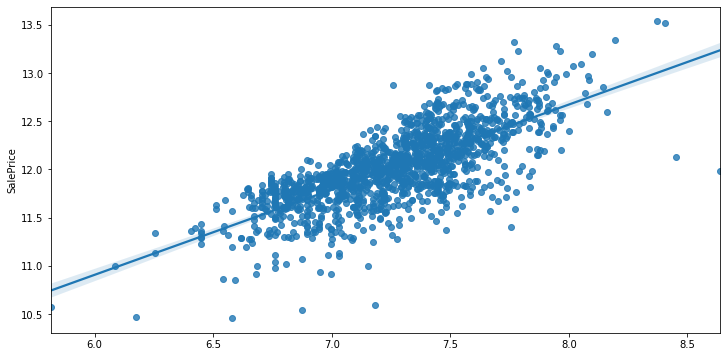

In [7]:
# 1,2층 면적 합에 대한 변수 생성
# skew 확인 후 log1p 적용해서 개선, log1p(y)와 선형관계를 이룸 -> 변수추가
feat_trial = (train['1stFlrSF'] + train['2ndFlrSF']).copy()
print("Skewness of the original intended feature:",skew(feat_trial))
print("Skewness of transformed feature", skew(np.log1p(feat_trial)))

# hence, we'll use the transformed feature thank you very much!
feat_trial = np.log1p(feat_trial)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# seaborn's regression plot (I liked it a lot. hence it found it's way here!)
sns.regplot(x=(feat_trial), y=np.log1p(train['SalePrice']), data=train, order=1);

In [8]:
# lets create the feature then
train['1stFlr_2ndFlr_Sf'] = np.log1p(train['1stFlrSF'] + train['2ndFlrSF'])
test['1stFlr_2ndFlr_Sf'] = np.log1p(test['1stFlrSF'] + test['2ndFlrSF'])

### Feature number 2 -> 1stflr+2ndflr+lowqualsf+GrLivArea = All_Liv_Area

let's see how this fares too

Skewness of the original intended feature: 1.427345461344283
Skewness of transformed feature 0.022891569554582734


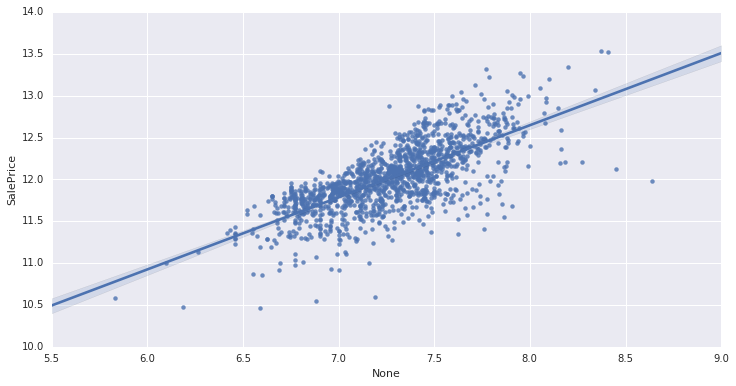

In [ ]:
# 추가적으로 sum 및 log1p 시도 -> log1p(y) 선형관계 -> 변수추가
feat_trial = (train['1stFlr_2ndFlr_Sf'] + train['LowQualFinSF'] + train['GrLivArea']).copy()
print("Skewness of the original intended feature:",skew(feat_trial))
print("Skewness of transformed feature", skew(np.log1p(feat_trial)))

# hence, we'll use the transformed feature thank you very much!
feat_trial = np.log1p(feat_trial)
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

# seaborn's regression plot (I liked it a lot. hence it found it's way here!)
sns.regplot(x=(feat_trial), y=np.log1p(train['SalePrice']), data=train, order=1);

In [ ]:
train['All_Liv_SF'] = np.log1p(train['1stFlr_2ndFlr_Sf'] + train['LowQualFinSF'] + train['GrLivArea'])
test['All_Liv_SF'] = np.log1p(test['1stFlr_2ndFlr_Sf'] + test['LowQualFinSF'] + test['GrLivArea'])

## Those were the two features I added. Let's move further to Step 2

In [ ]:
# get all features except Id and SalePrice
feats = train.columns.difference(['Id','SalePrice'])

# the most hassle free way of working with data is to concatenate them
# since there are many features that contain nan/null values in the test set
# that the train set doesn't
all_data = pd.concat((train.loc[:,feats],
                      test.loc[:,feats]))

## The To-Do List

### 1. Transform skewed numeric features using log(p+1) transformation making them more normal
### 2. Find dummy variables for categorical features
### 3. Replace nans/null values

In [ ]:
# log1p(y) 사용
# But first, we log transform the target: (reason well explained in Alexandru's AWESOME Notebook)
train["SalePrice"] = np.log1p(train["SalePrice"])

## 1. Transformations

###PS: log(p+1) transformations are not the available transformations for reducing skewness. I have tried sqrt, which yields better results as compared to log(p+1) (for certain features only. log(1+p) is a better way to go for this dataset at least)*emphasized text*

In [ ]:
# skew 개선 작업: sqrt 보다 log1p가 나음, threshold는 0.75
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

## 2. Let's get them dummies

In [ ]:
# getting dummies for all features. You can go the LabelEncoder way, but this method
# is more sound (and easier!!!) in my opinion
all_data = pd.get_dummies(all_data)

## 3. Fill them nan's

In [ ]:
# 평균값으로 결측치 대입
# 3. filling NA's with the mean of the column:
all_data = all_data.fillna(all_data[:train.shape[0]].mean())

In [ ]:
print(all_data.shape)
# creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

(2919, 290)


In [ ]:
# optional. Save these newly created matrices for later usage
# new_test = pd.DataFrame(X_test.copy())
# new_test['Id'] = test['Id'].copy()
# new_test.to_csv("../input/new_test.csv", index=False)

# new_train = pd.DataFrame(X_train.copy())
# new_train['SalePrice'] = y.copy()
# new_train.to_csv("../input/new_train.csv", index=False)

## All set. Moving on to incorporate this data
### But first, Let's devise a cross-validation methodology once and for all (thanks again, Alexandru)

In [ ]:
from sklearn.cross_validation import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

/opt/conda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression

### Let's get to work using LassoCV

In [ ]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=15000).fit(X_train, y)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

Mean: 0.123197247984
Min:  0.103486399166


### The above model yields a lb score of 0.12102* (some results I've gained through kaggle nb's and my local system have been different)

In [ ]:
# Lasso coef_ > 0 을 통해 변수 113개 추출 및 177개 drop
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 113 variables and eliminated the other 177 variables


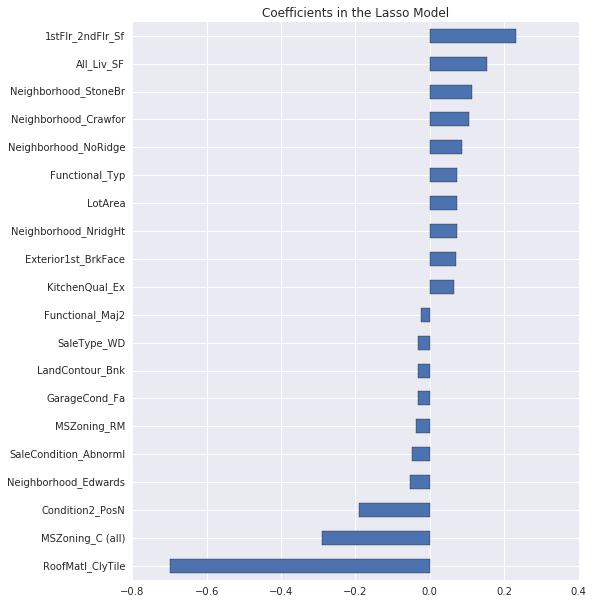

In [ ]:
# 앞에서 skew 개선 engineering 했던 변수들이 중요도가 높다!
# plotting feature importances!
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

### Woah. The first feature we engineered did end up being pretty important!!!! Way To go!

In [ ]:
# Let's make some predictions and submit it to the lb
test_preds = np.expm1(model_lasso.predict(X_test))
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission["SalePrice"] = test_preds
submission.to_csv("lasso_by_Sarthak.csv", index=False)